# Загрузка необходимых библиотек и данных:

In [45]:
import pandas as pd
import spacy
from collections import Counter
from tqdm import tqdm
import random
import gensim.downloader
import matplotlib.pyplot as plt
import nltk
import nltk.collocations

In [2]:
! python -m spacy download en_core_web_sm

     |████████████████████████████████| 13.9 MB 845 kB/s eta 0:00:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [3]:
def parse(path):
    g = open(path, 'rb')
    for l in g:
        yield eval(l)

def getDF(path):
    i = 0
    df = {}
    for d in parse(path):
        df[i] = d
        i += 1
    return pd.DataFrame.from_dict(df, orient='index')

In [4]:
data = getDF('/Users/asyakaryseva/Desktop/2022_2023_academic_year/NLP_2022/Electronics_5.json')

In [5]:
metadata = getDF('/Users/asyakaryseva/Desktop/2022_2023_academic_year/NLP_2022/meta_Electronics.json')

# 3 способа найти упоминания товаров в отзывах

1. Использование контекстно-свободных грамматик

Для этого способа выделения упоминаний товаров в отзывах необходим газеттир (например, "phone", "laptop"), тексты (например, тексты рецензий), в которых встречаются слова из газеттира, а также список правил, по которым будут выделять сущности.

Плюсы подхода:
- можно получить сущности, специфичные для текстов (например, в числе сущностей точно не окажется токенов, не встречающихся в тексте).

Минусы подхода:
- подход не позволяет эффективно справляться со случаями семантической неоднозначности.

2. Расширение газеттира с помощью векторных моделей

Для выделения сущности таким методов необходимо иметь газеттир. Расширение газеттира с помощью предобученных векторных моделей может не требовать обращения к текстам в выборке.

Плюсы подхода:
- подход является полуавтоматическим.

Минусы подхода:
- нет гарантии, что полученные сущности обязательно окажутся в текстах выборки.

3. Classification-based подход

Этот подход требует размеченных данных: необходимо заранее знать, какие из выделенных в тексте именных групп являются упоминаниями товаров.

Плюсы подхода:
- разметка позволяет чётко выделить границы каждой из сущностей.

Минусы подхода:
- в разметке сложно отобразить вложенность одной сущности в другую (в частности это невозможно сделать, используя BIOES разметку).

# Реализация способа #2

Можно обратиться к заголовкам товаров.

Я предполагаю, что среди 100 самых частотных униграмм или биграмм может оказаться довольно много названий товаров.

Можно начать с выделения униграмм. Имеет смысл смотреть только на существительные.

При этом данные очень-очень объёмные, работать с ними сложно и крайне долго даже с мультипроцессингом. Поэтому я беру случайные 100 тысяч сэмплов из названий товаров (и позже из текстов ревью):

In [7]:
random.seed(123)

titles = list(pd.unique(metadata['title']))
titles_100k = random.sample(titles, 100000)

unigrams = []

nlp = spacy.load("en_core_web_sm")

for doc in tqdm(nlp.pipe(titles_100k, disable=["tok2vec", "parser"], n_process = 4)):
    for token in doc:
        if token.pos_ == "NOUN" and token.text != "amp" and not token.is_stop and not token.is_punct:
            unigrams.append(token.text)

100000it [01:01, 1635.91it/s]


Теперь нужно посчитать, какие униграммы самые частотные.

In [8]:
counts_unigrams = Counter(unigrams)
most_occur_unigrams = counts_unigrams.most_common(100)
most_occur_unigrams

[('Case', 15982),
 ('Black', 12851),
 ('2', 11730),
 ('GB', 11124),
 ('USB', 10362),
 ('+', 9706),
 ('Cable', 9515),
 ('Camera', 9168),
 ('4', 8816),
 ('iPad', 7906),
 ('3', 7719),
 ('mm', 7657),
 ('Adapter', 7568),
 ('Cover', 7509),
 ('Laptop', 7135),
 ('Battery', 7029),
 ('Digital', 6603),
 ('Inch', 6348),
 ('Mini', 5957),
 ('Power', 5829),
 ('Screen', 5586),
 ('1', 5296),
 ('Wireless', 5292),
 ('Samsung', 5279),
 ('Tablet', 5277),
 ('Charger', 5208),
 ('Replacement', 5163),
 ('Bluetooth', 5161),
 ('HD', 4739),
 ('Apple', 4727),
 ('Kit', 4635),
 ('8', 4516),
 ('Pro', 4464),
 ('G', 4441),
 ('Card', 4413),
 ('Lens', 4245),
 ('Leather', 4019),
 ('Sony', 4017),
 ('LCD', 3964),
 ('Pack', 3857),
 ('White', 3754),
 ('Drive', 3730),
 ('6', 3696),
 ('Audio', 3643),
 ('Stand', 3567),
 ('5', 3559),
 ('Memory', 3468),
 ('Video', 3464),
 ('Series', 3464),
 ('Canon', 3459),
 ('Galaxy', 3435),
 ('High', 3423),
 ('10', 3378),
 ('LED', 3374),
 ('Hard', 3361),
 ('New', 3298),
 ('Protector', 3295),
 ('

In [9]:
import re
pattern = r'[0-9]+'
regex = re.compile(pattern)

unigrams_100 = []
for item in most_occur_unigrams:
    unigram = item[0]
    unigrams_100.append(unigram)
unigrams_wo_nums = [s.lower() for s in unigrams_100 if not regex.search(s)]

Можно выделить и биграммы:

In [10]:
bigrams = []

for doc in tqdm(nlp.pipe(titles_100k, disable=["tok2vec", "parser"], n_process = 4)):
    for i in range(len(doc)):
        j = i+1
        if j < len(doc):
            if doc[i].pos_ == "NOUN" and doc[j].pos_ == "NOUN" and doc[i].text != "amp" and doc[j].text != "amp" and not doc[i].is_stop and not doc[j].is_stop and not doc[i].is_punct and not doc[j].is_punct:
                bigrams.append((doc[i].text, doc[j].text))

100000it [01:12, 1386.88it/s]


In [11]:
counts_bigrams = Counter(bigrams)
most_occur_bigrams = counts_bigrams.most_common(100)
most_occur_bigrams

[(('Samsung', 'Galaxy'), 2501),
 (('Screen', 'Protector'), 2371),
 (('Case', 'Cover'), 2291),
 (('Digital', 'Camera'), 2262),
 (('Power', 'Supply'), 1814),
 (('Galaxy', 'Tab'), 1812),
 (('Apple', 'iPad'), 1752),
 (('8', 'GB'), 1704),
 (('USB', '2.0'), 1638),
 (('Hard', 'Drive'), 1532),
 (('3.5', 'mm'), 1524),
 (('iPad', 'Mini'), 1491),
 (('4', 'GB'), 1430),
 (('iPad', 'Air'), 1418),
 (('Remote', 'Control'), 1380),
 (('16', 'GB'), 1368),
 (('PU', 'Leather'), 1330),
 (('Memory', 'Card'), 1248),
 (('Leather', 'Case'), 1161),
 (('AC', 'Adapter'), 1146),
 (('32', 'GB'), 1112),
 (('2', 'GB'), 1017),
 (('USB', '3.0'), 1015),
 (('iPod', 'Touch'), 1014),
 (('Cover', 'Case'), 940),
 (('Wireless', 'Bluetooth'), 937),
 (('Battery', 'Charger'), 908),
 (('LCD', 'Screen'), 885),
 (('Kindle', 'Fire'), 864),
 (('iPad', '2'), 815),
 (('Flash', 'Drive'), 814),
 (('Touch', 'Screen'), 787),
 (('MacBook', 'Pro'), 750),
 (('USB', 'Cable'), 747),
 (('Toshiba', 'Satellite'), 741),
 (('High', 'Speed'), 733),
 (

In [12]:
bigrams_100 = []
for item in most_occur_bigrams:
    bigram = item[0][0] + ' ' + item[0][1]    
    bigrams_100.append(bigram)

Хотя при формировании списка биграмм был использован частеречный фильтр, в биграммах всё равно оказались числа. С одной стороны, это плюс – в списке есть такие биграммы, как "iPad 4". С другой стороны, биграммы, которые не похожи на названия товаров - "32 GB". От последних хотелось бы избавиться.

In [13]:
pattern = r'[0-9]+\s+[A-Z]+'
regex = re.compile(pattern)

bigrams_wo_nums = [s.lower() for s in bigrams_100 if not regex.search(s)]

Можно расширить словарь с помощью эмбеддингов.

In [14]:
glove_vectors = gensim.downloader.load('word2vec-google-news-300')

Но для этого все биграммы нужно привести к такому виду:

In [15]:
glove_vectors.most_similar('samsung_galaxy')

[('Vs_Samsung_Galaxy', 0.7181406617164612),
 ('htc_desire', 0.7067861557006836),
 ('Samsung_Captivate_Galaxy', 0.7025786638259888),
 ('Samsung_I####_Galaxy', 0.7009474635124207),
 ('HTC_DESIRE', 0.692426860332489),
 ('samsung_galaxy_s', 0.6906211376190186),
 ('Nokia_n##', 0.6802918314933777),
 ('Samsung_Fascinate_Galaxy', 0.675900399684906),
 ('Samsung_i####_Galaxy', 0.6748751401901245),
 ('Samsung_Galaxy_Portal', 0.6718400120735168)]

In [16]:
bigrams_formatted = []
for bigram in bigrams_wo_nums:
    bigram_lc = bigram.lower()
    bigram_formatted = bigram_lc.replace(" ", "_")
    bigrams_formatted.append(bigram_formatted)

Экспериментальным путём было выяснено, что газеттир с униграммами расширять с помощью модели не стоит: среди похожих слов оказываются слова совсем из других семантических полей (это релевантно для многозначных униграмм, например, "case"). Поэтому я хотела бы расширить только список биграмм:

In [25]:
similar_words = []
for bigram in tqdm(bigrams_formatted):
    try:
        most_similar = glove_vectors.most_similar(bigram)
        similar_words.extend(most_similar)
    except:
        pass

100%|██████████| 86/86 [00:03<00:00, 26.61it/s]


In [26]:
similar_words

[('Vs_Samsung_Galaxy', 0.7181406617164612),
 ('htc_desire', 0.7067861557006836),
 ('Samsung_Captivate_Galaxy', 0.7025786638259888),
 ('Samsung_I####_Galaxy', 0.7009474635124207),
 ('HTC_DESIRE', 0.692426860332489),
 ('samsung_galaxy_s', 0.6906211376190186),
 ('Nokia_n##', 0.6802918314933777),
 ('Samsung_Fascinate_Galaxy', 0.675900399684906),
 ('Samsung_i####_Galaxy', 0.6748751401901245),
 ('Samsung_Galaxy_Portal', 0.6718400120735168),
 ('screen_protectors', 0.6024205684661865),
 ('Click_Wheel', 0.5948165655136108),
 ('scratch_resistant', 0.5946007966995239),
 ('microfiber_cloth', 0.594084620475769),
 ('BodyGuardz', 0.5916203260421753),
 ('JAVOedge', 0.5907953381538391),
 ('Screen_Protector', 0.5898270010948181),
 ('Seidio', 0.5771571397781372),
 ('BoxWave', 0.574677050113678),
 ('iPhone_#G/#GS', 0.5746533870697021),
 ('apple_iphone', 0.6411125063896179),
 ('iphone4', 0.6391454339027405),
 ('htc_desire', 0.6385788917541504),
 ('iphone_3GS', 0.6344101428985596),
 ('ipad', 0.6340837478637

In [27]:
similar_words_new = []

for item in similar_words:
    product = item[0]
    product_formatted = product.replace("_", " ")
    product_formatted = re.sub(r'#+.', '', product_formatted)
    
    # хорошо бы ещё лемматизировать
    doc = nlp(product_formatted)
    lemmas = " ".join([token.lemma_ for token in doc])
    lemmas_lower = lemmas.lower()
    
    similar_words_new.append(lemmas_lower)
    
similar_words_new

['vs samsung galaxy',
 'htc desire',
 'samsung captivate galaxy',
 'samsung igalaxy',
 'htc desire',
 'samsung galaxy s',
 'nokia n',
 'samsung fascinate galaxy',
 'samsung igalaxy',
 'samsung galaxy portal',
 'screen protector',
 'click wheel',
 'scratch resistant',
 'microfiber cloth',
 'bodyguardz',
 'javoedge',
 'screen protector',
 'seidio',
 'boxwave',
 'iphone /s',
 'apple iphone',
 'iphone4',
 'htc desire',
 'iphone 3gs',
 'ipad',
 'android phone',
 'htc hd3',
 'apple ipad',
 'iphone ipad',
 'iphone unlock',
 'wall wart',
 'nimh cell',
 'main socket',
 'electret',
 'usb connector',
 '9v battery',
 'rechargable',
 'rsinterface',
 'ah battery',
 'displayport connector',
 'itouch',
 'droid x',
 'xoom',
 'macbook pro',
 'acer aspire',
 '8 gb',
 'ipad',
 'ig',
 'iphone',
 'iphone ipad',
 'charger',
 'recharger',
 'usb charger',
 'rechargable battery',
 'rechargeable battery',
 'battery',
 'nimh rechargeable battery',
 'battery charger',
 'battery recharger',
 'ac charger',
 'touchsc

Теперь можно объединить этот список с ранее составленным списком:

In [28]:
NEs = similar_words_new + bigrams_wo_nums + unigrams_wo_nums
unique_NEs = set(NEs)
len(unique_NEs)

309

In [29]:
unique_NEs

{'#',
 '+',
 '1 gb',
 '1 tb hdd',
 '3.5 mm',
 '8 gb',
 '9v battery',
 'ac',
 'ac adapter',
 'ac charger',
 'ac power',
 'accessory kit',
 'acer aspire',
 'active digitizer',
 'adapter',
 'adapter charger',
 'ah battery',
 'air',
 'air 2',
 'amazon kindle',
 'android',
 'android honeycomb tablet',
 'android phone',
 'android tablet',
 'apple',
 'apple ipad',
 'apple iphone',
 'apple ipod',
 'apple magic trackpad',
 'archos tablet',
 'asus',
 'asus eee',
 'asus eee pc seashell',
 'asus eeepc',
 'asus netbook',
 'asus transformer',
 'audio',
 'auto sleep',
 'autodesk 3ds max',
 'bag',
 'battery',
 'battery charger',
 'battery recharger',
 'belkin flip',
 'bitlocker',
 'black',
 'blue',
 'bluetooth',
 'bluetooth dongle',
 'bluetooth keyboard',
 'bluetooth speaker',
 'bodyguardz',
 'boxwave',
 'cable',
 'camcorder',
 'camera',
 'camera case',
 'canon',
 'canon eos',
 'canon powershot',
 'capacitive touchscreen',
 'car',
 'card',
 'card reader',
 'carrying case',
 'case',
 'case +',
 'case c

# Получение биграмм с полученными сущностями (NE + левый сосед)

Было решено посмотреть на левого соседа полученных сущностей: прилагательное в английском языке часто находится в препозиции по отношению к существительному; кроме того, выделенные сущности могут представлять собой прямые дополнения в предложениях типа "I like samsung galaxy".

Для начала нужно привести тексты к нижнему регистру, удалить из них стоп-слова, лемматизировать тексты.

In [23]:
random.seed(123)

reviews = list(data['reviewText'])
reviews_100k = random.sample(reviews, 100000)

reviews_normalized = []
lemmas = []

for doc in tqdm(nlp.pipe(reviews_100k, disable=["tok2vec", "parser"], n_process = 4)):
    for token in doc:
        if not token.is_stop and not token.is_punct:
            lemma = token.lemma_
            reviews_normalized.append(lemma)

100000it [05:01, 331.56it/s]


Поиск непосредственного левого контекста:

In [30]:
res = []

for i in tqdm(range(len(reviews_normalized))):
    for NE in unique_NEs:
        splitted_NE = NE.split(" ")
        if len(splitted_NE) == 1:
            if reviews_normalized[i] == splitted_NE:
                context = reviews_normalized[i-1]
                res.append(context + " " + NE)
        if len(splitted_NE) == 2:
            if reviews_normalized[i] == splitted_NE[0] and reviews_normalized[i+1] == splitted_NE[1]:
                context = reviews_normalized[i-1]
                res.append(context + " " + NE)
        if len(splitted_NE) == 3:
            if reviews_normalized[i] == splitted_NE[0] and reviews_normalized[i+1] == splitted_NE[1] and reviews_normalized[i+2] == splitted_NE[2]:
                context = reviews_normalized[i-1]
                res.append(context + " " + NE)


100%|██████████| 5459328/5459328 [11:27<00:00, 7943.60it/s]


In [32]:
counts_collocations = Counter(res)

Нужно добавить частотный фильтр. Для этого необходимо посмотреть на распределение частот составленных коллокаций:

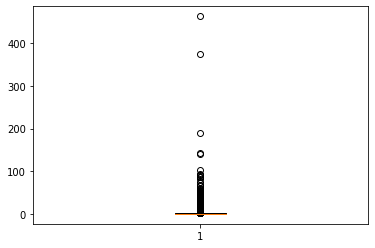

In [34]:
x = list(counts_collocations.values())

plt.boxplot(x)
plt.show()

Нужно как минимум избавиться от выбросов, я бы также добавила фильтр для нижней границы частоты:

In [37]:
filtered_counts = dict(filter(lambda x: x[1] < 80 and x[1] > 3, dict(counts_collocations).items()))

В списке коллокаций нужно оставить только те, что есть в отфильтрованных по частоте коллокациях:

In [38]:
res_filtered = []
for r in res:
    if r in filtered_counts.keys():
        res_filtered.append(r)

# Ранжирование n-грамм с помощью 3 коллокационных метрик

## t-test

In [57]:
collocations = filtered_counts.keys()
bigram_measures = nltk.collocations.BigramAssocMeasures()

splitted_col = ""
w2 = ""
w1 = ""
n_ii = 0
n_ix = 0
n_xi = 0

collocations_t = {}

for col in collocations:
    splitted_col = col.split(" ")
    w2 = splitted_col[1:]
    w2 = " ".join(w2)
    w1 = splitted_col[0]
    
    n_all = len(res_filtered)
    for r in res_filtered:
        if w1 in r and w2 in r:
            n_ii += 1
        if w1 in r:
            n_ix += 1
        if w2 in r:
            n_xi += 1
    
    collocations_t[w1 + " " + w2] = bigram_measures.student_t(n_ii, (n_ix, n_xi), n_all)
    sorted_collocations_t = sorted(collocations_t.items(), key=lambda x:x[1], reverse=True)[:50]

print(sorted_collocations_t)

[('wireless flash drive', 1.398572884811417), ('old dell laptop', 0.09276248725790026), ('use smart cover', -0.6868788226299696), ('holds ipad air', -1.0168347524191033), ('standing leather case', -3.7192106287054827), ('wireless bluetooth speaker', -3.8487041233995747), ('perfectly macbook pro', -4.281650154509614), ('jambox wireless bluetooth', -4.783628872349178), ('responsive touch screen', -5.281846485148772), ('converting dvd player', -6.1554433466179725), ('new power supply', -13.347652022601837), ('buy dvd player', -19.96573194182897), ('separate hard drive', -33.63715132981188), ('fault screen protector', -39.26397247936812), ('getting screen protector', -44.42462233589344), ('fast memory card', -50.66218236122157), ('  8 gb', -360.6230638020521), ('internal rechargeable battery', -394.7709248136988), ('10 sd card', -396.0985495994552), ('battery battery charger', -427.4710004129747), ('mini usb port', -443.9222557892373), ('included power cord', -453.7004536628898), ('batteri

In [58]:
collocations = filtered_counts.keys()
splitted_col = ""
w2 = ""
w1 = ""
n_ii = 0
n_ix = 0
n_xi = 0

collocations_pmi = {}

for col in collocations:
    splitted_col = col.split(" ")
    w2 = splitted_col[1:]
    w2 = " ".join(w2)
    w1 = splitted_col[0]
    
    n_all = len(res_filtered)
    for r in res_filtered:
        if w1 in r and w2 in r:
            n_ii += 1
        if w1 in r:
            n_ix += 1
        if w2 in r:
            n_xi += 1
    
    collocations_pmi[w1 + " " + w2] = bigram_measures.pmi(n_ii, (n_ix, n_xi), n_all)
    sorted_collocations_pmi = sorted(collocations_pmi.items(), key=lambda x:x[1], reverse=True)[:50]

print(sorted_collocations_pmi)

[('wireless flash drive', 1.7335381819700348), ('old dell laptop', 0.02247888104656326), ('use smart cover', -0.22862749499812907), ('holds ipad air', -0.2891162248124388), ('standing leather case', -0.5213529962418022), ('wireless bluetooth speaker', -0.5492546885239022), ('perfectly macbook pro', -0.7060175884959285), ('jambox wireless bluetooth', -0.7130264748586157), ('converting dvd player', -0.7246290478447222), ('responsive touch screen', -0.7987609580836406), ('new power supply', -1.1735377787735288), ('buy dvd player', -1.5088507862093188), ('separate hard drive', -2.020741435910672), ('fault screen protector', -2.1604289848397045), ('getting screen protector', -2.2616666924797357), ('fast memory card', -2.3765215642406226), ('  8 gb', -4.19932697987765), ('battery battery charger', -4.234713833838811), ('internal rechargeable battery', -4.296543531093377), ('use memory card', -4.309688509744259), ('10 sd card', -4.3181695449043005), ('mini usb port', -4.408787429644551), ('ba

In [59]:
collocations = filtered_counts.keys()
splitted_col = ""
w2 = ""
w1 = ""
n_ii = 0
n_ix = 0
n_xi = 0

collocations_chi_sq = {}

for col in collocations:
    splitted_col = col.split(" ")
    w2 = splitted_col[1:]
    w2 = " ".join(w2)
    w1 = splitted_col[0]
    
    n_all = len(res_filtered)
    for r in res_filtered:
        if w1 in r and w2 in r:
            n_ii += 1
        if w1 in r:
            n_ix += 1
        if w2 in r:
            n_xi += 1
    
    collocations_chi_sq[w1 + " " + w2] = bigram_measures.chi_sq(n_ii, (n_ix, n_xi), n_all)
    sorted_collocations_chi_sq = sorted(collocations_chi_sq.items(), key=lambda x:x[1], reverse=True)[:50]

print(sorted_collocations_chi_sq)

[('free screen protector', 3781187.902044154), ('leather carrying case', 2578882.747872432), ('stand apple ipad', 2250221.543750822), ('plugged usb port', 819209.1603181512), ('enclosure usb 3.0', 576287.3236704741), ('uspeed usb 3.0', 453017.2498996475), ('apple ipad mini', 412174.9323881006), ('tb hard drive', 299079.54654467624), ('great hdmi cable', 259774.67880669388), ('need sd card', 232167.75790834395), ('buying sd card', 215369.6033005013), ('camera sd card', 186414.09484295166), ('standard usb cable', 174731.8623043791), ('vcr dvd player', 166907.14204651653), ('running os x', 165833.80687944766), ('protect ipod touch', 144884.67775124856), ('buy kindle fire', 137424.06775564633), ('usb sd card', 99404.99180582521), ('external power supply', 95294.8360374075), ('scan dvd player', 92523.19144350574), ('device usb port', 88018.45018213546), ('  ipad mini', 54455.83570386457), ('recommend hdmi cable', 52941.66977091669), ('2009 macbook pro', 51724.69002222212), ('super wide angl

Сложно выбрать результат ранжирования коллокаций по какой-либо из метрик: результаты во многом пересекаются. Тем не менее, я бы выбрала список коллокаций, ранжированных по метрике Хи-квадрат. Среди полученных коллокаций есть потенциально полезные для отчёта вхождения: 'free screen protector', 'recommend hdmi cable', 'super wide angle', 'lens wide angle', 'came screen protector'.

# Группировка полученных коллокаций по NE, примеры для 5 товаров

In [99]:
sorted_collocations_chi_sq = sorted(collocations_chi_sq.items(), key=lambda x:x[1], reverse=True)
NEs_collocations = {}

for NE in unique_NEs:
    collocation_list = []
    for collocation in sorted_collocations_chi_sq:
        if NE + " " in collocation[0]:
            collocation_list.append(collocation[0])
            NEs_collocations[NE] = collocation_list

In [102]:
five_items = {k: NEs_collocations[k] for k in list(NEs_collocations)[:5]}
five_items

{'nikon': ['nikon digital slr', 'nikon digital camera'],
 'case': ['case screen protector',
  'case ipod touch',
  'case ipad 2',
  'case ipad mini',
  'case smart cover',
  'case hard drive',
  'case bluetooth keyboard',
  'case kindle fire',
  'case usb 3.0',
  'case ipad air',
  'case galaxy tab',
  'case apple ipad',
  'case macbook pro',
  'folio case cover',
  'leather case cover',
  'case samsung galaxy',
  'case hard case',
  'case macbook air',
  'case power supply',
  'case amazon kindle',
  'case memory card',
  'case heavy duty',
  'case leather case',
  'case sd card',
  'case usb cable',
  'case micro usb',
  'case asus transformer'],
 'pro': ['pro retina display', 'pro bluetooth keyboard', 'pro hard drive'],
 'digital': ['compact digital camera',
  'mp digital camera',
  'shoot digital camera',
  'small digital cameras',
  'cmos digital slr',
  'cmos digital slr camera',
  'digital slr camera',
  'canon digital slr',
  'shoot digital cameras',
  'quality digital camera',